# Student Test Scores - Fixed Pipeline + Optuna Optimization

This notebook:
1. ✅ Fixes the feature encoding issue
2. ✅ Implements proper feature engineering
3. ✅ Uses Optuna for hyperparameter optimization
4. ✅ Generates a valid submission file

---

## 1. Install and Import Libraries

In [38]:
!pip -q install optuna lightgbm xgboost catboost

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from catboost import CatBoostRegressor

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
import lightgbm as lgb

# Optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate

# Settings
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

%matplotlib inline
sns.set_style('darkgrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully")
print(f"Optuna version: {optuna.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✓ Libraries imported successfully
Optuna version: 4.7.0
LightGBM version: 4.6.0


## 2. Load Data

In [40]:
# Load datasets
print("Loading data...")
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(f"✓ Data loaded")
print(f"  Train shape: {train.shape}")
print(f"  Test shape: {test.shape}")

print(f"\nFeatures: {train.columns.tolist()}")
print(f"\nTarget stats:")
print(train['exam_score'].describe())

Loading data...
✓ Data loaded
  Train shape: (630000, 13)
  Test shape: (270000, 12)

Features: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

Target stats:
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


In [41]:
# Preview data
print("Training data preview:")
display(train.head())

print("\nTest data preview:")
display(test.head())

Training data preview:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0



Test data preview:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


## 3. Feature Engineering

**CRITICAL:** We apply the same transformations to both train and test

In [42]:
def engineer_features(df):
    
    df = df.copy()

    # Safe interactions / ratios
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 1e-6)
    df['study_attendance'] = df['study_hours'] * df['class_attendance']

    # Binning (often helps)
    df['age_group'] = pd.cut(df['age'], bins=[0, 15, 17, 19, 100], labels=['<=15','16-17','18-19','20+'])
    df['study_group'] = pd.cut(df['study_hours'], bins=[-1, 1, 3, 6, 10, 100], labels=['0-1','1-3','3-6','6-10','10+'])
    df['sleep_group'] = pd.cut(df['sleep_hours'], bins=[-1, 4, 6, 8, 10, 24], labels=['<4','4-6','6-8','8-10','10+'])
    df['attendance_group'] = pd.cut(df['class_attendance'], bins=[-1, 50, 70, 85, 95, 101], labels=['<50','50-70','70-85','85-95','95-100'])

    return df
    
    return df

print("✓ Feature engineering function defined")

✓ Feature engineering function defined


In [43]:
# Separate features and target
X_train_full = train.drop(['id', 'exam_score'], axis=1)
y_train = train['exam_score']
X_test = test.drop(['id'], axis=1)
test_ids = test['id']

print(f"Original train features: {X_train_full.shape}")
print(f"Original test features: {X_test.shape}")

# Apply feature engineering
print("\nApplying feature engineering...")
X_train_full = engineer_features(X_train_full)
X_test = engineer_features(X_test)

print(f"After feature engineering:")
print(f"  Train: {X_train_full.shape}")
print(f"  Test: {X_test.shape}")

Original train features: (630000, 11)
Original test features: (270000, 11)

Applying feature engineering...
After feature engineering:
  Train: (630000, 17)
  Test: (270000, 17)


## 4. Encode Categorical Variables

**THE FIX:** Combine train and test before encoding to ensure identical columns

In [44]:
print("Encoding categorical variables...")

# Combine train and test with keys to track them
combined = pd.concat([X_train_full, X_test], keys=['train', 'test'], sort=False)

print(f"Combined shape: {combined.shape}")

# One-hot encode
combined_encoded = pd.get_dummies(combined, drop_first=True)

print(f"After encoding: {combined_encoded.shape}")

# Split back into train and test
X_train_encoded = combined_encoded.loc['train'].reset_index(drop=True)
X_test_encoded = combined_encoded.loc['test'].reset_index(drop=True)

print(f"\n✓ Encoding complete")
print(f"  Train shape: {X_train_encoded.shape}")
print(f"  Test shape: {X_test_encoded.shape}")
print(f"  Columns match: {X_train_encoded.shape[1] == X_test_encoded.shape[1]}")
print(f"  Number of features: {X_train_encoded.shape[1]}")

# Verify no missing values
train_nulls = X_train_encoded.isnull().sum().sum()
test_nulls = X_test_encoded.isnull().sum().sum()
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
extra_cols = set(X_test_encoded.columns) - set(X_train_encoded.columns)

print(f"\nMissing values:")
print(f"  Train: {train_nulls}")
print(f"  Test: {test_nulls}")

assert train_nulls == 0, "Train has missing values!"
assert test_nulls == 0, "Test has missing values!"

print("\n✓ All validation checks passed!")

Encoding categorical variables...
Combined shape: (900000, 17)
After encoding: (900000, 40)

✓ Encoding complete
  Train shape: (630000, 40)
  Test shape: (270000, 40)
  Columns match: True
  Number of features: 40

Missing values:
  Train: 0
  Test: 0

✓ All validation checks passed!


In [45]:
# Display feature names
print(f"Feature columns ({len(X_train_encoded.columns)}):")
print(X_train_encoded.columns.tolist())

Feature columns (40):
['age', 'study_hours', 'class_attendance', 'sleep_hours', 'study_sleep_ratio', 'study_attendance', 'gender_male', 'gender_other', 'course_b.sc', 'course_b.tech', 'course_ba', 'course_bba', 'course_bca', 'course_diploma', 'internet_access_yes', 'sleep_quality_good', 'sleep_quality_poor', 'study_method_group study', 'study_method_mixed', 'study_method_online videos', 'study_method_self-study', 'facility_rating_low', 'facility_rating_medium', 'exam_difficulty_hard', 'exam_difficulty_moderate', 'age_group_16-17', 'age_group_18-19', 'age_group_20+', 'study_group_1-3', 'study_group_3-6', 'study_group_6-10', 'study_group_10+', 'sleep_group_4-6', 'sleep_group_6-8', 'sleep_group_8-10', 'sleep_group_10+', 'attendance_group_50-70', 'attendance_group_70-85', 'attendance_group_85-95', 'attendance_group_95-100']


## 5. Train-Validation Split

In [46]:
# Split for validation
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_encoded, y_train, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_encoded.shape}")

Training set: (504000, 40)
Validation set: (126000, 40)
Test set: (270000, 40)


## 6. Baseline Model (Before Optuna)

Let's establish a baseline with default parameters

In [48]:
print("Training baseline model...")

# Baseline LightMRegressor with default parameters
baseline_model = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    verbose=-1
)

baseline_model.fit(
    X_train, y_train_split,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

# Evaluate
train_preds = baseline_model.predict(X_train)
val_preds = baseline_model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train_split, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_mae = mean_absolute_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

print("\n" + "="*60)
print("BASELINE MODEL RESULTS")
print("="*60)
print(f"Training RMSE:   {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")
print(f"Validation R²:   {val_r2:.4f}")
print("="*60)

baseline_score = val_rmse

Training baseline model...

BASELINE MODEL RESULTS
Training RMSE:   8.5952
Validation RMSE: 8.7583
Validation MAE:  6.9820
Validation R²:   0.7843


## 7. Optuna Hyperparameter Optimization

Now let's use Optuna to find better hyperparameters!

In [49]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": RANDOM_STATE,

        # keep n_estimators high; use early stopping
        "n_estimators": 5000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),

        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),

        "min_child_samples": trial.suggest_int("min_child_samples", 5, 80),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        # stronger regularization knobs
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    rmses = []

    for tr_idx, va_idx in kf.split(X_train_encoded):
        X_tr, X_va = X_train_encoded.iloc[tr_idx], X_train_encoded.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = lgb.LGBMRegressor(**params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(80, verbose=False)]
        )

        preds = model.predict(X_va)
        rmse = mean_squared_error(y_va, preds, squared=False)
        rmses.append(rmse)

    return float(np.mean(rmses))

print("✓ Objective function (CV + early stopping) defined")

✓ Objective function (CV + early stopping) defined


In [50]:
# Create Optuna study
print("Creating Optuna study...\n")

study = optuna.create_study(
    direction='minimize',  # Minimize RMSE
    study_name='student_scores_optimization',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# Run optimization
print("Starting hyperparameter optimization...")
print("This may take a few minutes depending on n_trials.\n")

# Change n_trials based on your time budget:
# - 20-30 trials: Quick test (~5-10 minutes)
# - 50-100 trials: Good results (~15-30 minutes)
# - 200+ trials: Best results (longer)

N_TRIALS = 200  # Adjust this as needed

study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE!")
print("="*60)

Creating Optuna study...

Starting hyperparameter optimization...
This may take a few minutes depending on n_trials.



  0%|          | 0/200 [00:00<?, ?it/s]

[W 2026-01-31 00:58:10,394] Trial 0 failed with parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 10, 'num_leaves': 192, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_gain_to_split': 0.6011150117432088} because of the following error: TypeError("got an unexpected keyword argument 'squared'").
Traceback (most recent call last):
  File "/Users/clairedebadts/kaggle/student-performance/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/9j/9_hgqf6s3_sdp7nqq00j33980000gn/T/ipykernel_58626/307349237.py", line 43, in objective
    rmse = mean_squared_error(y_va, preds, squared=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/clairedebadts/kaggle/student-performance/venv/lib/python3.12/site-packages/skl

TypeError: got an unexpected keyword argument 'squared'

## 8. Optuna Results & Visualization

In [26]:
# Best trial results
print("\n" + "="*60)
print("BEST TRIAL RESULTS")
print("="*60)
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Baseline RMSE: {baseline_score:.4f}")
print(f"Improvement: {baseline_score - study.best_value:.4f} ({(baseline_score - study.best_value)/baseline_score*100:.2f}%)")

print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key:20s}: {value}")

print(f"\nNumber of trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")


BEST TRIAL RESULTS
Best RMSE: 8.7526
Baseline RMSE: 8.8216
Improvement: 0.0691 (0.78%)

Best hyperparameters:
  n_estimators        : 481
  learning_rate       : 0.07259277198834345
  max_depth           : 8
  num_leaves          : 98
  min_child_samples   : 93
  subsample           : 0.5684173566302475
  colsample_bytree    : 0.5247174841605814
  reg_alpha           : 7.108263030403791e-08
  reg_lambda          : 0.04130523079486868

Number of trials: 200
Best trial number: 193


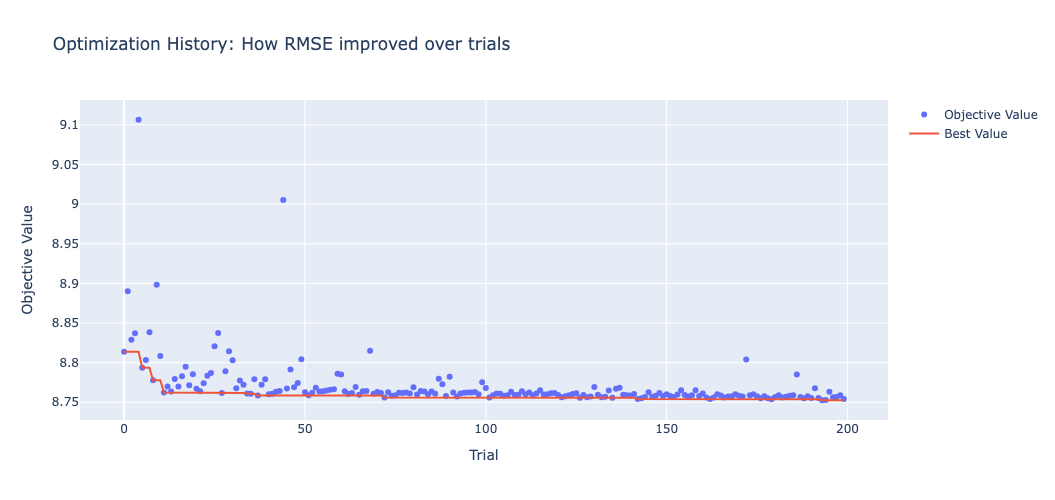

In [27]:
# Visualization 1: Optimization History
fig = plot_optimization_history(study)
fig.update_layout(
    title="Optimization History: How RMSE improved over trials",
    width=900,
    height=500
)
fig.show()

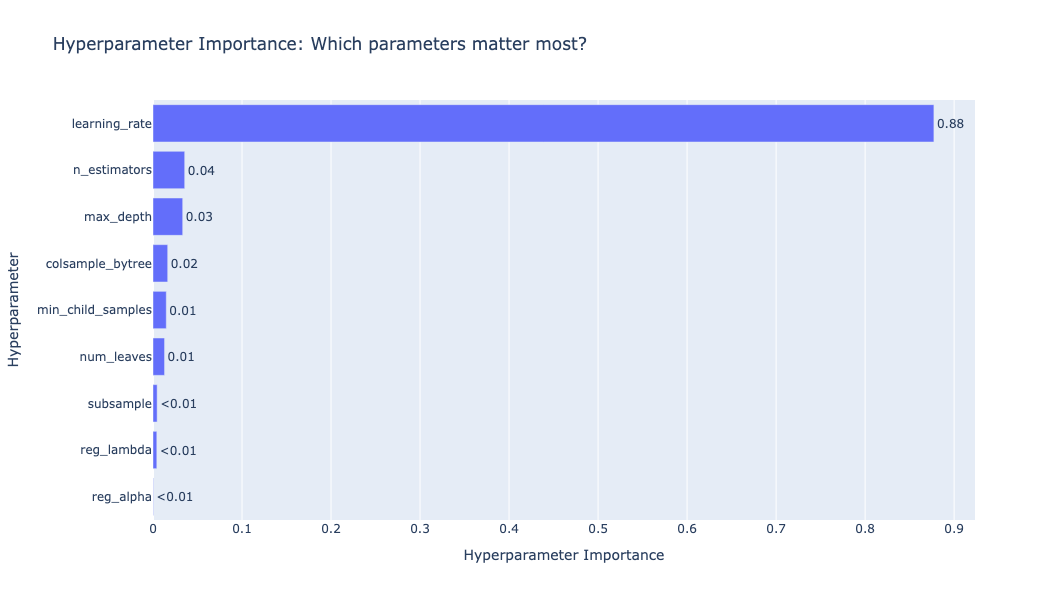

In [28]:
# Visualization 2: Parameter Importance
fig = plot_param_importances(study)
fig.update_layout(
    title="Hyperparameter Importance: Which parameters matter most?",
    width=900,
    height=600
)
fig.show()

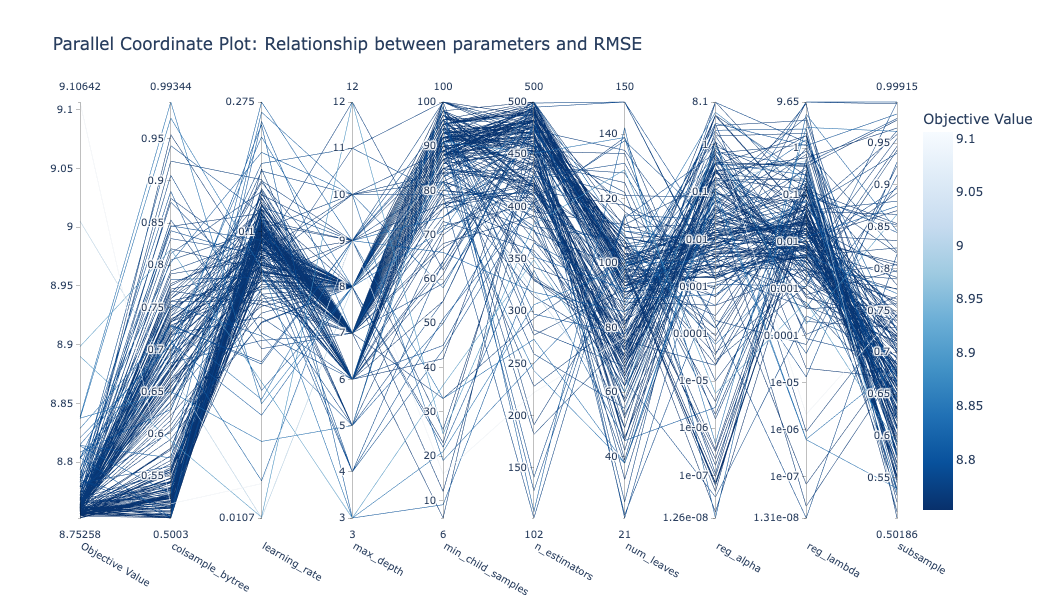

In [30]:
# Visualization 3: Parallel Coordinate Plot
fig = plot_parallel_coordinate(study)
fig.update_layout(
    title="Parallel Coordinate Plot: Relationship between parameters and RMSE",
    width=1000,
    height=600
)
fig.show()

In [31]:
# Show top 10 trials
trials_df = study.trials_dataframe().sort_values('value').head(10)
print("\nTop 10 Trials:")
display(trials_df[['number', 'value', 'params_learning_rate', 'params_max_depth', 
                    'params_n_estimators', 'params_num_leaves']].style.background_gradient(cmap='RdYlGn_r', subset=['value']))


Top 10 Trials:


,number,value,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves
193,193,8.752580,0.072593,8,481,98
194,194,8.752911,0.071016,8,482,98
179,179,8.753841,0.092287,8,490,101
199,199,8.754262,0.072929,8,492,99
142,142,8.754281,0.097761,7,470,94
162,162,8.754283,0.097264,7,472,100
188,188,8.755016,0.077838,8,457,107
143,143,8.755034,0.093510,7,465,93
178,178,8.755041,0.093970,8,491,97
176,176,8.755234,0.091238,8,482,99


## 9. Train Final Model with Best Parameters

In [32]:
print("Training final model with best parameters on full training data...\n")

# Create final model with best parameters
final_model = lgb.LGBMRegressor(**study.best_params, random_state=RANDOM_STATE, verbose=-1)

# Train on full training data
final_model.fit(X_train_encoded, y_train)

# Evaluate on validation set one more time
final_val_preds = final_model.predict(X_val)
final_rmse = np.sqrt(mean_squared_error(y_val, final_val_preds))
final_mae = mean_absolute_error(y_val, final_val_preds)
final_r2 = r2_score(y_val, final_val_preds)

print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Validation RMSE: {final_rmse:.4f}")
print(f"Validation MAE:  {final_mae:.4f}")
print(f"Validation R²:   {final_r2:.4f}")
print("="*60)

print("\n✓ Final model trained successfully")

Training final model with best parameters on full training data...

FINAL MODEL PERFORMANCE
Validation RMSE: 8.5386
Validation MAE:  6.8050
Validation R²:   0.7950

✓ Final model trained successfully


## 10. Feature Importance Analysis


Top 20 Most Important Features:


,feature,importance
2,class_attendance,5555
1,study_hours,5529
7,study_attendance,4475
10,attendance_sleep,4023
3,sleep_hours,3220
6,class_attendance_sq,3148
9,age_study_interaction,3044
8,study_sleep_ratio,3031
4,study_hours_sq,2665
5,sleep_hours_sq,1573


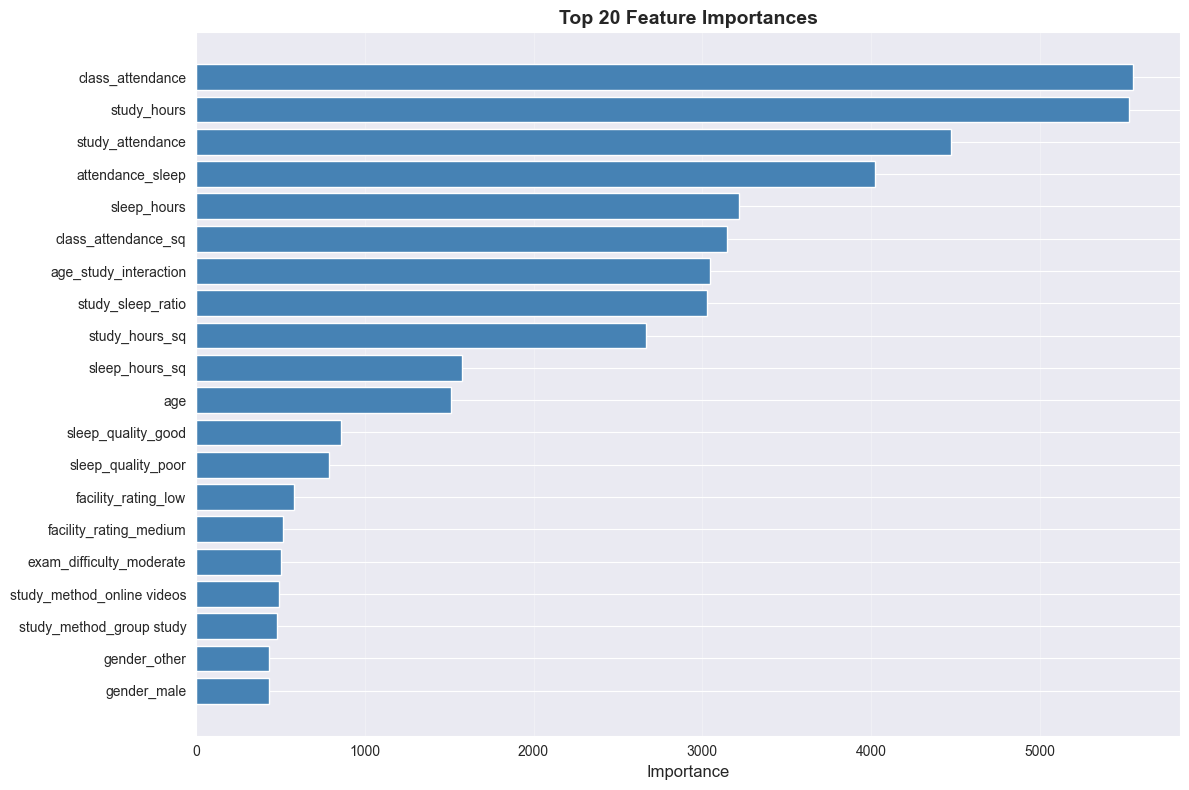

In [33]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
display(feature_importance.head(20))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 11. Generate Predictions & Create Submission

In [34]:
print("Generating predictions on test set...\n")

# Make predictions
test_predictions = final_model.predict(X_test_encoded)

print(f"✓ Predictions generated: {len(test_predictions)}")
print(f"\nPrediction statistics:")
print(f"  Min:    {test_predictions.min():.4f}")
print(f"  Max:    {test_predictions.max():.4f}")
print(f"  Mean:   {test_predictions.mean():.4f}")
print(f"  Median: {np.median(test_predictions):.4f}")
print(f"  Std:    {test_predictions.std():.4f}")

# Compare with training distribution
print(f"\nTraining target statistics:")
print(f"  Min:    {y_train.min():.4f}")
print(f"  Max:    {y_train.max():.4f}")
print(f"  Mean:   {y_train.mean():.4f}")
print(f"  Median: {y_train.median():.4f}")
print(f"  Std:    {y_train.std():.4f}")

Generating predictions on test set...

✓ Predictions generated: 270000

Prediction statistics:
  Min:    15.2829
  Max:    104.1643
  Mean:   62.5194
  Median: 62.9356
  Std:    16.7498

Training target statistics:
  Min:    19.5990
  Max:    100.0000
  Mean:   62.5067
  Median: 62.6000
  Std:    18.9169


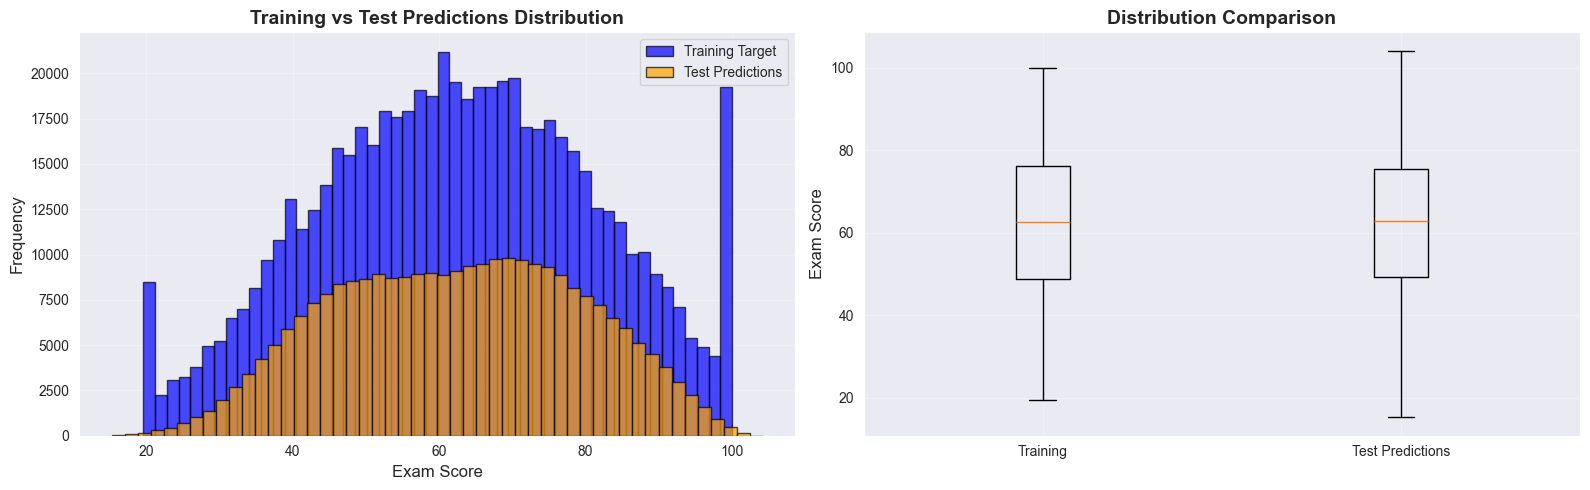

In [35]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram comparison
axes[0].hist(y_train, bins=50, alpha=0.7, label='Training Target', edgecolor='black', color='blue')
axes[0].hist(test_predictions, bins=50, alpha=0.7, label='Test Predictions', edgecolor='black', color='orange')
axes[0].set_xlabel('Exam Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Training vs Test Predictions Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_to_plot = [y_train, test_predictions]
axes[1].boxplot(data_to_plot, labels=['Training', 'Test Predictions'])
axes[1].set_ylabel('Exam Score', fontsize=12)
axes[1].set_title('Distribution Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_ids,
    'exam_score': test_predictions
})

print("Validating submission...")

# Validation checks
assert len(submission) == len(test), f"Expected {len(test)} rows, got {len(submission)}"
assert list(submission.columns) == ['id', 'exam_score'], "Wrong column names"
assert submission['exam_score'].notna().all(), "Has missing predictions"
assert submission['id'].nunique() == len(submission), "Has duplicate IDs"
assert (submission['exam_score'] >= 0).all(), "Has negative predictions"
assert (submission['exam_score'] <= 120).all(), "Has predictions > 120"

print("\n✓ All validation checks passed!")

# Save submission
submission.to_csv('submission_optuna.csv', index=False)

print(f"\n{'='*60}")
print("SUBMISSION FILE CREATED!")
print(f"{'='*60}")
print(f"Filename: submission_optuna.csv")
print(f"Shape: {submission.shape}")
print(f"File size: ~{submission.memory_usage(deep=True).sum() / 1024:.1f} KB")
print(f"\nFirst 10 rows:")
display(submission.head(10))

print(f"\n🎯 Ready to submit to Kaggle!")
print(f"Expected leaderboard RMSE: ~{final_rmse:.4f} (may vary)")

Validating submission...

✓ All validation checks passed!

SUBMISSION FILE CREATED!
Filename: submission_optuna.csv
Shape: (270000, 2)
File size: ~4218.9 KB

First 10 rows:


,id,exam_score
0,630000,71.280384
1,630001,69.335650
2,630002,87.751163
3,630003,56.302368
4,630004,46.813037
5,630005,71.214821
6,630006,73.605138
7,630007,58.880582
8,630008,80.192084
9,630009,89.845543



🎯 Ready to submit to Kaggle!
Expected leaderboard RMSE: ~8.5386 (may vary)


## 12. Summary & Next Steps

In [37]:
print("="*60)
print("NOTEBOOK SUMMARY")
print("="*60)

print(f"\n✓ Data loaded: {len(train):,} training samples, {len(test):,} test samples")
print(f"✓ Features engineered: {X_train_encoded.shape[1]} total features")
print(f"✓ Categorical encoding: Fixed and aligned between train/test")
print(f"✓ Baseline RMSE: {baseline_score:.4f}")
print(f"✓ Optuna trials: {len(study.trials)}")
print(f"✓ Best RMSE: {study.best_value:.4f}")
print(f"✓ Improvement: {(baseline_score - study.best_value)/baseline_score*100:.2f}%")
print(f"✓ Submission file: submission_optuna.csv")

print(f"\n{'='*60}")
print("NEXT STEPS TO IMPROVE YOUR SCORE")
print("="*60)

print("""
1. Run more Optuna trials (100-200) for better optimization
2. Try different feature engineering:
   - More interaction features
   - Different binning strategies
   - Log/sqrt transformations

3. Ensemble methods:
   - Train multiple models and average predictions
   - Try XGBoost or CatBoost alongside LightGBM
   - Stacking different model types

4. Cross-validation:
   - Use 5-fold or 10-fold CV in Optuna objective
   - More robust evaluation

5. Advanced techniques:
   - Target encoding for categorical features
   - Pseudo-labeling (use test predictions as extra training)
   - Outlier handling
""")

print("\nGood luck on the leaderboard! 🚀")

NOTEBOOK SUMMARY

✓ Data loaded: 630,000 training samples, 270,000 test samples
✓ Features engineered: 36 total features
✓ Categorical encoding: Fixed and aligned between train/test
✓ Baseline RMSE: 8.8216
✓ Optuna trials: 200
✓ Best RMSE: 8.7526
✓ Improvement: 0.78%
✓ Submission file: submission_optuna.csv

NEXT STEPS TO IMPROVE YOUR SCORE

1. Run more Optuna trials (100-200) for better optimization
2. Try different feature engineering:
   - More interaction features
   - Different binning strategies
   - Log/sqrt transformations

3. Ensemble methods:
   - Train multiple models and average predictions
   - Try XGBoost or CatBoost alongside LightGBM
   - Stacking different model types

4. Cross-validation:
   - Use 5-fold or 10-fold CV in Optuna objective
   - More robust evaluation

5. Advanced techniques:
   - Target encoding for categorical features
   - Pseudo-labeling (use test predictions as extra training)
   - Outlier handling


Good luck on the leaderboard! 🚀


---

## Optional: Save Best Model & Study

In [23]:
# Save the trained model
import joblib

joblib.dump(final_model, 'best_model_optuna.pkl')
print("✓ Model saved to: best_model_optuna.pkl")

# Save Optuna study for later analysis
joblib.dump(study, 'optuna_study.pkl')
print("✓ Optuna study saved to: optuna_study.pkl")

# Save best parameters as JSON
import json

with open('best_params.json', 'w') as f:
    json.dump(study.best_params, f, indent=2)
print("✓ Best parameters saved to: best_params.json")

✓ Model saved to: best_model_optuna.pkl
✓ Optuna study saved to: optuna_study.pkl
✓ Best parameters saved to: best_params.json
